In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import documents as docs
import textcomparisons as tc
import random
import time
import json

start = time.time()

def readArticles(path):
    """ Reads df of articles from the given path, and adds a column
    to store the Document-processed article """
    article_df = pd.read_csv(path)
    article_df["doc"] = None
    return article_df

def dict_by_ids(df, ids):
    """ Given a dataframe of articles and a list of article ids, 
    returns a dictionary with ids as keys and Documents as items, 
    computing and storing the Documents back in the df as needed
    """
    doc_dict = {}
    for doc_id in ids:
        row = df["id"] == doc_id
        doc = df.loc[row, "doc"].iloc[0]
        if doc is None:
            doc = docs.Document(df.loc[row, "text"].iloc[0], clean = False)
            df.loc[row, "doc"] = doc
        doc_dict[doc_id] = doc
    return doc_dict

data_folder = "data"
article_df = pd.read_pickle(os.path.join(data_folder, "article_df_20190601"))

# events = [event for event in np.unique(article_df["event"]) if not np.isnan(event)]
event_path = os.path.join(data_folder, "eventDict2019-06-01.json")
with open(event_path, encoding = "utf8") as json_file:
    events = json.load(json_file)
print(events.keys())
article_df.head(3)

print("Setup time: %d seconds" % np.round(time.time() - start))

dict_keys(['singletons', 'incompleteFingerprints', 'algoGroups', 'events', 'wordDict', 'entityDict'])
Setup time: 3 seconds


In [2]:
N = len(article_df)
N_top50 = np.sum(1 - np.isnan(article_df["event"]))
print("Number of singletons: %d" % len(events['singletons']))
print("Number of articles clustered into top 50 events: %d/%d (.%d)" % (N_top50, N, round(N_top50/N, 2) * 100))

ac = tc.ArticleComparisons()

Number of singletons: 64173
Number of articles clustered into top 50 events: 33124/100756 (.33)


Mean, 5/25/50/75/95 percentiles: 2822.965 [ 161.75  843.   1883.   4115.75 8157.7 ]


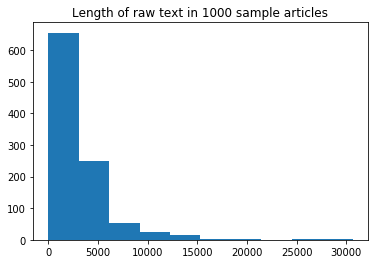

In [23]:
n = 1000
sample = random.sample(list(article_df["id"]), n)
article_dict = dict_by_ids(article_df, sample)
start = time.time()

text_len = [len(article_dict[id].text) for id in article_dict.keys()]
plt.hist(text_len)
plt.title("Length of raw text in %d sample articles" % n)
print("Mean, 5/25/50/75/95 percentiles:", np.mean(text_len), np.percentile(text_len, [5, 25, 50, 75, 95]))

In [24]:
start = time.time()
# for i in range(len(article_df)):
for i in sample:
    if (len(sample) > 1000 and i % 100 == 0):
        print(i, time.time() - start, "seconds elapsed")
    # Suspicious if article contains keywords
    isPaywall(i)

In [26]:
article_dict_good = dict_by_ids(article_df, [i for i in sample if article_df.loc[i, "paywall"] == 0])
article_dict_bad = dict_by_ids(article_df, [i for i in sample if article_df.loc[i, "paywall"] > 0])
print("Sample 'bad' articles: ")
for s in [str(article_dict[i]) for i in random.sample(list(article_dict_bad), 10)]:
    print(s, "\n")
len(article_dict_bad), len(article_dict_good)

Sample 'bad' articles: 
Press J to jump to the feed. Press question mark to learn the rest of the keyboard shortcuts 
 u/Dully-YT 

Don't have an account? Sign Up Today 
 My Account 

Don't have an account? Sign Up Today 
 My Account 
 Clear skies. Low near 50F. Winds light and variable.. 
 Tonight 
 Clear skies. Low near 50F. Winds light and variable. 
 Updated: June 1, 2019 @ 11:37 pm 
 Noesi, Diaz spur New Orleans to 3-0 win over Nashville 
 Jun 1, 2019 
 NASHVILLE, Tenn. (AP) -- Isan Diaz homered and had two hits, driving in two, and Hector Noesi struck out nine hitters over seven innings as the New Orleans Baby Cakes beat the Nashville Sounds 3-0 on Saturday. 
 Noesi (5-2) allowed four hits while walking two to pick up the win. 
 In the sixth inning, New Orleans went up 1-0 on a home run by Diaz. The Baby Cakes scored again in the eighth when Diaz hit an RBI triple and then scored on a single by Yadiel Rivera. 
 Tim Dillard (3-5) went six innings, allowing one run and six hits whi

(183, 817)

In [27]:
score_mat = ac.jac_score_mat(article_dict_bad)
axislabels = list(article_dict_bad.keys())
clusters = ac.get_article_clusters(article_dict_bad)
ac.prop_unique_clusters()
# 76/400 "bad" articles, .5s, 67.1% unique
# 189/1000 bad articles, 2.5s, 49.2% unique
# 186/1000 bad articles, 7.3s, 52.2% unique
# 184/1000 bad articles, 12s, 49.5% unique
# 183/1000 bad articles, 9.5s, 49.5% 

0 / 183 done, 0.0 seconds elapsed
37 / 183 done, 3.74 seconds elapsed
55 / 183 done, 5.18 seconds elapsed
92 / 183 done, 7.21 seconds elapsed
110 / 183 done, 8.15 seconds elapsed
165 / 183 done, 9.51 seconds elapsed


0.4950980392156863

In [28]:
score_mat = ac.jac_score_mat(article_dict_good)
axislabels = list(article_dict_good.keys())
clusters = ac.get_article_clusters()
ac.prop_unique_clusters()
# 324/400 "good" articles, 8s, 79.0% unique
# 817/1000 good articles, 2.25h, 69% unique

0 / 817 done, 0.0 seconds elapsed
82 / 817 done, 2128.16 seconds elapsed
327 / 817 done, 5715.41 seconds elapsed
409 / 817 done, 6628.89 seconds elapsed
572 / 817 done, 7605.37 seconds elapsed
654 / 817 done, 8017.32 seconds elapsed


0.4950980392156863

In [3]:
n = 1000
singleton_sample = random.sample(list(article_df.loc[np.isnan(article_df["event"]), "id"]), n)
singleton_dict_good = dict_by_ids(article_df, [i for i in singleton_sample if article_df.loc[i, "paywall"] == 0])
singleton_dict_bad = dict_by_ids(article_df, [i for i in singleton_sample if article_df.loc[i, "paywall"] > 0])

In [6]:
score_mat = ac.jac_score_mat(singleton_dict_bad)
print(ac.prop_unique_clusters())

print("%s seconds taken" % np.round(time.time() - start, 2), "for %d bad singleton articles" % len(singleton_dict_bad))
# 261/1000 bad singleton articles, 1.5m, 45.6% unique

0.4559386973180077
104.42 seconds taken for 261 bad singleton articles


In [ ]:
score_mat = ac.jac_score_mat(singleton_dict_good)
print(ac.prop_unique_clusters())

print("%s seconds taken" % np.round(time.time() - start, 2), "for %d good singleton articles" % len(singleton_dict_good))
# 739/1000 good singleton articles, , 

0 / 739 done, 0.0 seconds elapsed
74 / 739 done, 824.09 seconds elapsed
148 / 739 done, 1545.58 seconds elapsed
222 / 739 done, 2182.34 seconds elapsed
296 / 739 done, 2822.85 seconds elapsed
370 / 739 done, 3377.11 seconds elapsed


In [ ]:
results = pd.read_csv(os.path.join("results", "results_20190601_clusters_temp.csv"))
plt.scatter(results.loc[:, "n"], results.loc[:, "unique25"])
plt.title("Unique articles in clusters on 6/01/19, with maximum similarity of .25")
plt.xlabel("# articles in cluster")
plt.ylabel("% of unique articles")
print("Average % unique articles, weighted by cluster size (thresh = 0.25): ", np.sum(results.loc[:, "n"] * results.loc[:, "unique25"])/np.sum(results.loc[:, "n"]))
plt.figure()
plt.scatter(results.loc[:, "n"], results.loc[:, "unique75"])
plt.title("Unique articles in clusters on 6/01/19, with maximum similarity of .75")
plt.xlabel("# articles in cluster")
plt.ylabel("% of unique articles")
print("Average % unique articles, weighted by cluster size (thresh = 0.75): ", np.sum(results.loc[:, "n"] * results.loc[:, "unique75"])/np.sum(results.loc[:, "n"]))